In [1]:
#Google
from google.colab import drive

import os
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

#Utils
from scipy import stats
import itertools
from sklearn import metrics

#Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

#Data augmentation
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler

#Validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import StratifiedKFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [2]:
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/DCU'

/content/drive/My Drive/DCU


#Data loading

In [4]:
df = pd.read_csv('OPEN_MERGE_200611.csv')
#df = pd.read_csv('CLOSE_MERGE_200611.csv')

In [5]:
df_source = df[['FN', 'MA', 'MS', 'DT', 'DP']]

#오류 데이터 삭제 (모터 전류값이 0) --> Data_20200529_121245.csv
del_idx = df_source[df_source['FN']== 'Data_20200529_121245.csv'].index
df_source = df_source.drop(del_idx)

#파일 갯수 확인
df_source['FN'].value_counts()

Data_20200529_161928.csv    114
Data_20200529_103346.csv    106
Data_20200529_112256.csv     99
Data_20200529_102155.csv     94
Data_20200529_164709.csv     94
                           ... 
Data_20200529_102131.csv     74
Data_20200529_161103.csv     74
Data_20200529_101850.csv     74
Data_20200529_101829.csv     71
Data_20200529_160904.csv     68
Name: FN, Length: 999, dtype: int64

In [6]:
df_count = df_source[['FN', 'DT']]
df_count = df_count.drop_duplicates()
df_count.groupby(by=['DT'], as_index=False).size()



DT
0    650
1    100
2     49
3    100
4     50
5     50
dtype: int64

In [7]:
df_count['DT'].value_counts(normalize=True) * 100

0    65.065065
3    10.010010
1    10.010010
5     5.005005
4     5.005005
2     4.904905
Name: DT, dtype: float64

#Functions for statistical feature extraction

In [8]:
def cal_rms(x):
    return np.sqrt(sum(x**2/len(x)))

def cal_rss(x):    
    return np.sqrt(sum(x**2))  

def cal_skew(x):
  return stats.skew(x)  

def cal_kurtosis(x):
  return stats.kurtosis(x)

def cal_crest(x):
  rms = cal_rms(x)
  mx = x.max()
  return abs(mx)/rms

def cal_clearance(x):
  a = x.max()
  s = sum(np.sqrt(abs(x)))
  b = (s/len(x))**2
  return a/b

def cal_shape(x):
    a = cal_rms(x)
    b = sum(abs(x))/len(x)
    return a/b

def cal_impulse(x):
    a = x.max()
    b = sum(abs(x))/len(x)    
    return a/b

def cal_peak_to_peak(x):
    a = x.max()
    b = x.min()
    return a-b

#Confusion Matrix 생성

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = cm * 100
      print("\nNormalized confusion matrix")
  else:
      print('\nConfusion matrix, without normalization')
  print(cm)
  print ()

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.0f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

#Feature extraction

In [10]:
df_mean = df_source.groupby(['FN','DT'], as_index=False).mean().rename(columns={"MA":"MA_MEAN", "MS":"MS_MEAN"}) #평균
#df_mean.rename(index={'MA':'MEAD_MA'}, inplace=True)

df_max = df_source.groupby(['FN','DT'], as_index=False).max().rename(columns={"MA":"MA_MAX", "MS":"MS_MAX"}) #최고
df_min = df_source.groupby(['FN','DT'], as_index=False).min().rename(columns={"MA":"MA_MIN", "MS":"MS_MIN"})#최저
df_std = df_source.groupby(['FN','DT']).std().reset_index().rename(columns={"MA":"MA_STD", "MS":"MS_STD"})#표준편차

df_rms = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_rms, 'MS':cal_rms}).rename(columns={"MA":"MA_RMS", "MS":"MS_RMS"}) #RMS
df_rss = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_rss, 'MS':cal_rss}).rename(columns={"MA":"MA_RSS", "MS":"MS_RSS"}) #RSS

#df_skew = df_source.groupby(['FN','DT']).skew() #왜도
df_skew = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_skew, 'MS':cal_skew}).rename(columns={"MA":"MA_SKEW", "MS":"MS_SKEW"}) #왜도
df_kurt = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_kurtosis, 'MS':cal_kurtosis}).rename(columns={"MA":"MA_KURT", "MS":"MS_KURT"}) #첨도

df_crest = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_crest, 'MS':cal_crest}).rename(columns={"MA":"MA_CREST", "MS":"MS_CREST"}) #파고율/파형률
df_clearance = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_clearance, 'MS':cal_clearance}).rename(columns={"MA":"MA_CLEARANCE", "MS":"MS_CLEARANCE"}) 

df_shape = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_shape, 'MS':cal_shape}).rename(columns={"MA":"MA_SHAPE", "MS":"MS_SHAPE"}) 
df_impulse = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_impulse, 'MS':cal_impulse}).rename(columns={"MA":"MA_IMPULSE", "MS":"MS_IMPULSE"})
df_peak = df_source.groupby(['FN','DT'], as_index=False).agg({'MA':cal_peak_to_peak, 'MS':cal_peak_to_peak}).rename(columns={"MA":"MA_PEAK", "MS":"MS_PEAK"})

In [13]:
result = pd.merge(df_mean, df_max, on=['FN','DT'], how='inner')
#result = pd.merge(result, df_min, on=['FN','DT'], how='inner')
result = pd.merge(result, df_std, on=['FN','DT'], how='inner')
result = pd.merge(result, df_rms, on=['FN','DT'], how='inner')
result = pd.merge(result, df_rss, on=['FN','DT'], how='inner')
result = pd.merge(result, df_skew, on=['FN','DT'], how='inner')
result = pd.merge(result, df_kurt, on=['FN','DT'], how='inner')
result = pd.merge(result, df_crest, on=['FN','DT'], how='inner')
result = pd.merge(result, df_clearance, on=['FN','DT'], how='inner')
result = pd.merge(result, df_shape, on=['FN','DT'], how='inner')
result = pd.merge(result, df_impulse, on=['FN','DT'], how='inner')
result = pd.merge(result, df_peak, on=['FN','DT'], how='inner')

In [14]:
result.head()

,FN,DT,MA_MEAN,MS_MEAN,DP_x,MA_MAX,MS_MAX,DP_y,MA_STD,MS_STD,DP,MA_RMS,MS_RMS,MA_RSS,MS_RSS,MA_SKEW,MS_SKEW,MA_KURT,MS_KURT,MA_CREST,MS_CREST,MA_CLEARANCE,MS_CLEARANCE,MA_SHAPE,MS_SHAPE,MA_IMPULSE,MS_IMPULSE,MA_PEAK,MS_PEAK
0,Data_20200529_095156.csv,0,0.408333,151.238095,434.761905,3.1,354,648,0.650525,122.784425,228.086996,0.764775,194.343768,7.009280,1781.190052,2.759987,0.005670,7.694057,-1.597192,4.053479,1.821515,14.158318,3.423160,1.872919,1.285019,7.591837,2.340680,3.1,354
1,Data_20200529_095233.csv,0,0.421429,151.857143,434.333333,3.2,355,648,0.661155,123.449433,227.920528,0.780720,195.240694,7.155418,1789.410517,2.699029,0.003460,7.387240,-1.608336,4.098780,1.818268,14.083604,3.420958,1.852556,1.285687,7.593220,2.337723,3.2,355
2,Data_20200529_095251.csv,0,0.425882,152.447059,435.588235,3.2,358,648,0.664070,123.331484,226.885449,0.785606,195.631827,7.242928,1803.636327,2.715143,-0.009737,7.553378,-1.598284,4.073290,1.829968,13.853250,3.437968,1.844654,1.283277,7.513812,2.348356,3.2,358
3,Data_20200529_095307.csv,0,0.421176,152.682353,435.552941,3.2,356,648,0.663162,122.738806,226.859696,0.782304,195.446879,7.212489,1801.931186,2.753818,-0.014859,7.697103,-1.596702,4.090480,1.821467,13.870486,3.390200,1.857426,1.280088,7.597765,2.331638,3.2,356
4,Data_20200529_095323.csv,0,0.409412,152.517647,435.635294,3.1,357,649,0.647821,122.678210,227.150771,0.763121,195.280613,7.035624,1800.398289,2.762444,-0.011606,7.759275,-1.593548,4.062268,1.828138,14.059402,3.403296,1.863944,1.280380,7.571839,2.340713,3.1,357


#Data upsampling

In [15]:
smote = SMOTE(random_state=0)

x_data = result.iloc[:,2:]
y_data = result.iloc[:,1:2]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)


#SMOTE를 이용하여 Data upscaling
x_train_over,y_train_over = smote.fit_sample(x_train,y_train)

print('적용 전 : ', x_train.shape, y_train.shape)
print('적용 후 : ', x_train_over.shape, y_train_over.shape)
print('적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

적용 전 :  (699, 27) (699, 1)
적용 후 :  (2718, 27) (2718,)
적용 후 레이블 값 분포: 
 5    453
3    453
1    453
4    453
2    453
0    453
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is dep

#Data partitioning (train 70%, test 30%)

In [16]:
x_data = result.iloc[:,2:]
y_data = result.iloc[:,1:2]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

#데이터 정규화 (평균이 0과 표준편차가 1이 되도록 변환되도록 StandardScaler 사용)

In [17]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [18]:
x_train, x_train_scaled 

(      MA_MEAN     MS_MEAN        DP_x  ...  MS_IMPULSE  MA_PEAK  MS_PEAK
 730  0.386747  156.481928  431.132530  ...    2.230289      3.1      349
 669  0.386905  154.428571  432.892857  ...    2.246994      3.1      347
 639  0.383133  156.590361  431.361446  ...    2.209587      3.1      346
 803  0.374390  163.682927  427.500000  ...    2.144390      3.1      351
 736  0.386747  156.373494  430.493976  ...    2.225441      3.1      348
 ..        ...         ...         ...  ...         ...      ...      ...
 767  0.369880  159.445783  429.831325  ...    2.201375      3.1      349
 72   2.041892  157.432432  344.202703  ...    2.610644      4.9      409
 908  0.379268  155.670732  433.304878  ...    2.241911      3.0      349
 235  0.398810  154.559524  433.000000  ...    2.270970      3.1      351
 37   0.415294  152.200000  434.341176  ...    2.332457      3.2      355
 
 [699 rows x 27 columns],
 array([[-0.41952136,  0.36795405,  0.19200699, ..., -0.22067378,
         -0.247892

#XGBoost Model

reference : https://m.blog.naver.com/PostView.nhn?blogId=gustn3964&logNo=221431933811&proxyReferer=https:%2F%2Fwww.google.com%2F

In [23]:
xgb = xgb.XGBClassifier(colsample_bylevel = 0.9,
                              colsample_bytree = 0.8,
                              gamma = 0,
                              max_depth = 6,
                              min_child_weight = 3,
                              n_estimators = 50,
                              nthread = 5,
                              random_state = 2,
                              objective='multi:softmax')

xgb.fit(x_train_scaled, y_train)
y_pred = xgb.predict(x_test_scaled)
score = metrics.accuracy_score(y_test, y_pred)

print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.95



Confusion matrix, without normalization
[[192   2   2   0   1   0]
 [  1  30   0   1   0   0]
 [  7   0   7   0   0   0]
 [  0   0   0  26   0   0]
 [  0   0   0   1  14   0]
 [  0   0   0   0   0  16]]



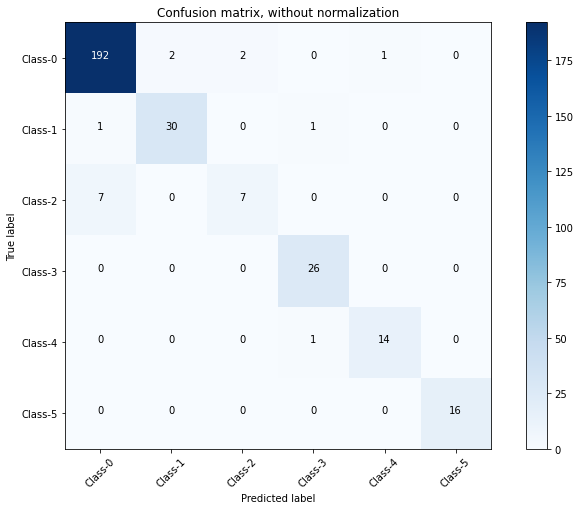


Normalized confusion matrix
[[ 97.46192893   1.01522843   1.01522843   0.           0.50761421
    0.        ]
 [  3.125       93.75         0.           3.125        0.
    0.        ]
 [ 50.           0.          50.           0.           0.
    0.        ]
 [  0.           0.           0.         100.           0.
    0.        ]
 [  0.           0.           0.           6.66666667  93.33333333
    0.        ]
 [  0.           0.           0.           0.           0.
  100.        ]]



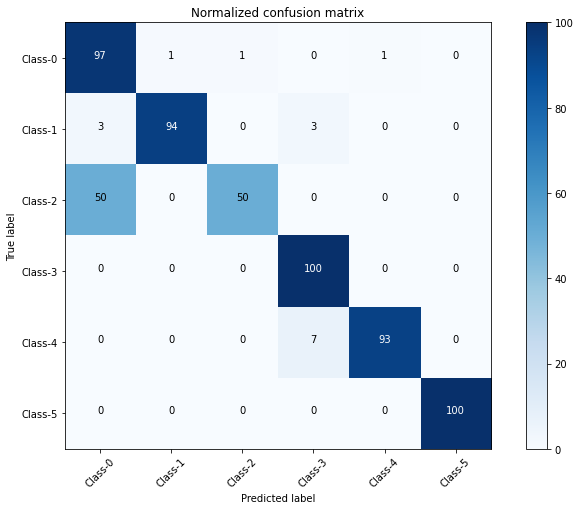

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5])


class_names = ['Class-0','Class-1','Class-2','Class-3','Class-4','Class-5']
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
targets = ['Class-0', 'Class-1', 'Class-2', 'Class-3', 'Class-4', 'Class-5']
print(classification_report(y_test, y_pred, target_names=targets))

In [21]:
xgb = xgb.XGBClassifier()
param_grid = {'booster' :['gbtree'],
                 'silent':[False],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,3],
                 'nthread':[5],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50,70],
                 'objective':['multi:softmax'],
                 'random_state':[2]}

cv = KFold(n_splits=6, random_state=1)

gcv = GridSearchCV(xgb, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=4)

gcv.fit(x_train_scaled, y_train)
print('final params', gcv.best_params_)
print('best score', gcv.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



final params {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.5, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 70, 'nthread': 5, 'objective': 'multi:softmax', 'random_state': 2, 'silent': False}
best score 0.9542071912761568



Confusion matrix, without normalization
[[194   1   2   0   0   0]
 [  0  31   0   1   0   0]
 [  7   0   7   0   0   0]
 [  0   0   0  26   0   0]
 [  0   0   0   1  14   0]
 [  0   0   0   0   0  16]]



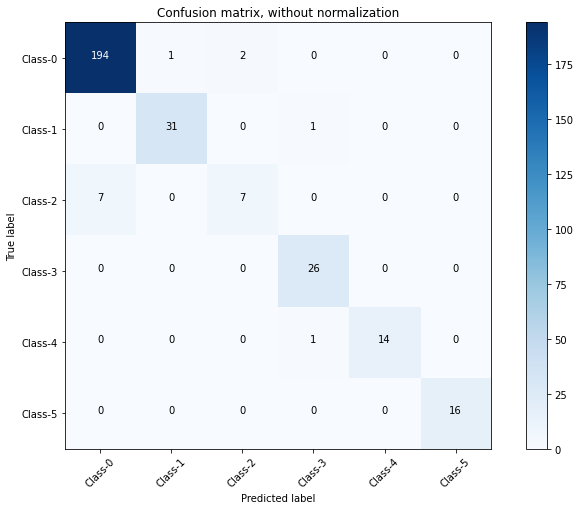


Normalized confusion matrix
[[ 98.47715736   0.50761421   1.01522843   0.           0.
    0.        ]
 [  0.          96.875        0.           3.125        0.
    0.        ]
 [ 50.           0.          50.           0.           0.
    0.        ]
 [  0.           0.           0.         100.           0.
    0.        ]
 [  0.           0.           0.           6.66666667  93.33333333
    0.        ]
 [  0.           0.           0.           0.           0.
  100.        ]]



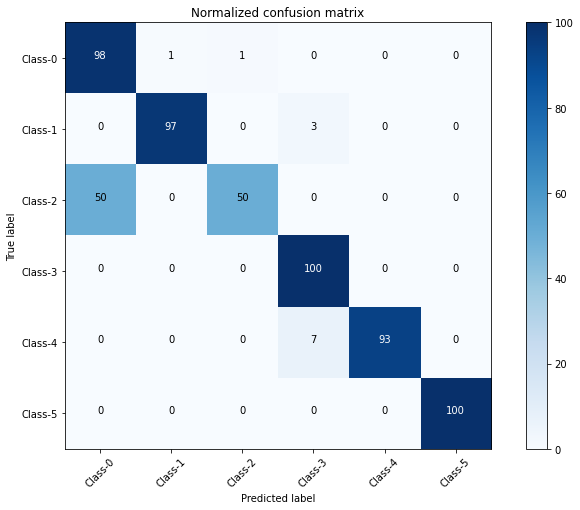

In [22]:
xgb_best = gcv.best_estimator_
y_pred = xgb_best.predict(x_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5])


class_names = ['Class-0','Class-1','Class-2','Class-3','Class-4','Class-5']
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

#Create Random Forest Model

In [24]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=20) #criterion = entropy/gini
rf.fit(x_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#Feature 중요도

In [25]:
features = x_data.columns.values

trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode = 'markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale = 'Portland',
        showscale = True
    ),
    text = features
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Feature Importance (Open)',
    hovermode = 'closest',
    xaxis = dict(
        ticklen = 5,
        showgrid = False,
        zeroline = False,
        showline = False
    ),
    yaxis = dict(
        title = 'Feature Importance',
        showgrid = False,
        zeroline = False,
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter0616')

#Feature Bar Chart

In [26]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),reverse = False)))

trace2 = go.Bar(
    x = x,
    y = y,
    marker=dict(
        color = x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name = 'Random Forest Feature importance',
    orientation = 'h'
)

layout = dict(
    title = 'Feature importances (Close)',
    width = 800,
    height = 700,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True
    )
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

#Prediction

In [27]:
#rf = RandomForestClassifier(criterion='entropy', n_estimators=20) #criterion = entropy/gini
#rf.fit(x_train_scaled, y_train)
y_pred = rf.predict(x_test_scaled)

- 정확도(accuracy)
 : 전체 샘플 중 맞게 예측한 샘플 수의 비율
- 정밀도(Precision)
: 올바르게 분류된 데이터의 비율은?
- 재현율(recall) 
 : 올바르게 분류된 데이터의 비율은?
-F점수
 : 정확률과 재현율의 조화평균

- Reference site : 
https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [28]:
accuracy_score(y_test, y_pred)

0.94

In [29]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5])
cm

array([[193,   2,   2,   0,   0,   0],
       [  1,  29,   0,   2,   0,   0],
       [ 10,   0,   4,   0,   0,   0],
       [  0,   0,   0,  26,   0,   0],
       [  0,   0,   0,   1,  14,   0],
       [  0,   0,   0,   0,   0,  16]])


Confusion matrix, without normalization
[[193   2   2   0   0   0]
 [  1  29   0   2   0   0]
 [ 10   0   4   0   0   0]
 [  0   0   0  26   0   0]
 [  0   0   0   1  14   0]
 [  0   0   0   0   0  16]]



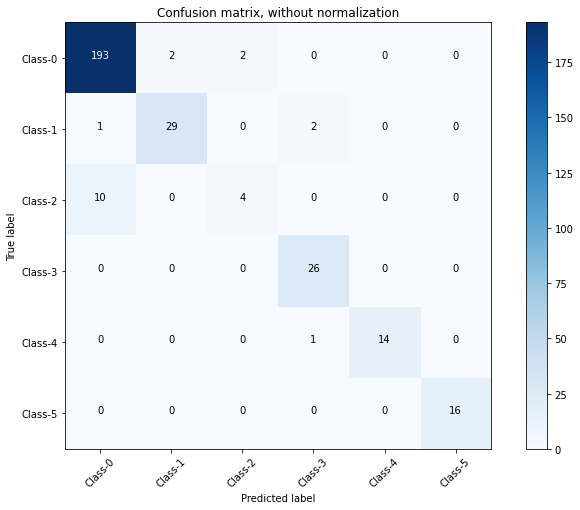


Normalized confusion matrix
[[ 97.96954315   1.01522843   1.01522843   0.           0.
    0.        ]
 [  3.125       90.625        0.           6.25         0.
    0.        ]
 [ 71.42857143   0.          28.57142857   0.           0.
    0.        ]
 [  0.           0.           0.         100.           0.
    0.        ]
 [  0.           0.           0.           6.66666667  93.33333333
    0.        ]
 [  0.           0.           0.           0.           0.
  100.        ]]



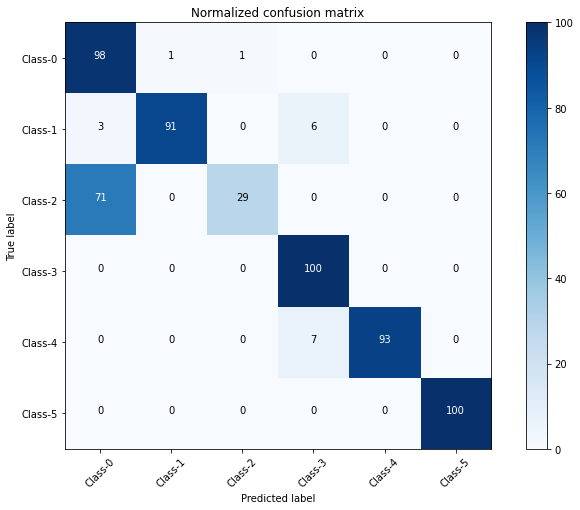

In [30]:
class_names = ['Class-0','Class-1','Class-2','Class-3','Class-4','Class-5']
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

- Class-0 : 정상
- Class-1 : 이물질끼임
- Class-2 : 닫힘 걸리고 재닫힘
- Class-3 : 만차
- Class-4 : spindle
- Class-5 : stress

In [41]:
targets = ['Class-0', 'Class-1', 'Class-2', 'Class-3', 'Class-4', 'Class-5']
print(classification_report(y_test, y_pred, target_names=targets))

              precision    recall  f1-score   support

     Class-0       0.96      0.98      0.97       197
     Class-1       0.91      0.97      0.94        32
     Class-2       0.83      0.36      0.50        14
     Class-3       0.93      1.00      0.96        26
     Class-4       1.00      0.93      0.97        15
     Class-5       1.00      1.00      1.00        16

    accuracy                           0.95       300
   macro avg       0.94      0.87      0.89       300
weighted avg       0.95      0.95      0.94       300



In [59]:
#Class-0과 Class-2 파형 비교
df_class0 = df_source[(df_source.DT == 0) & (df_source.FN == 'Data_20200529_095156.csv')]
df_class2 = df_source[(df_source.DT == 2) & (df_source.FN == 'Data_20200529_121304.csv')]

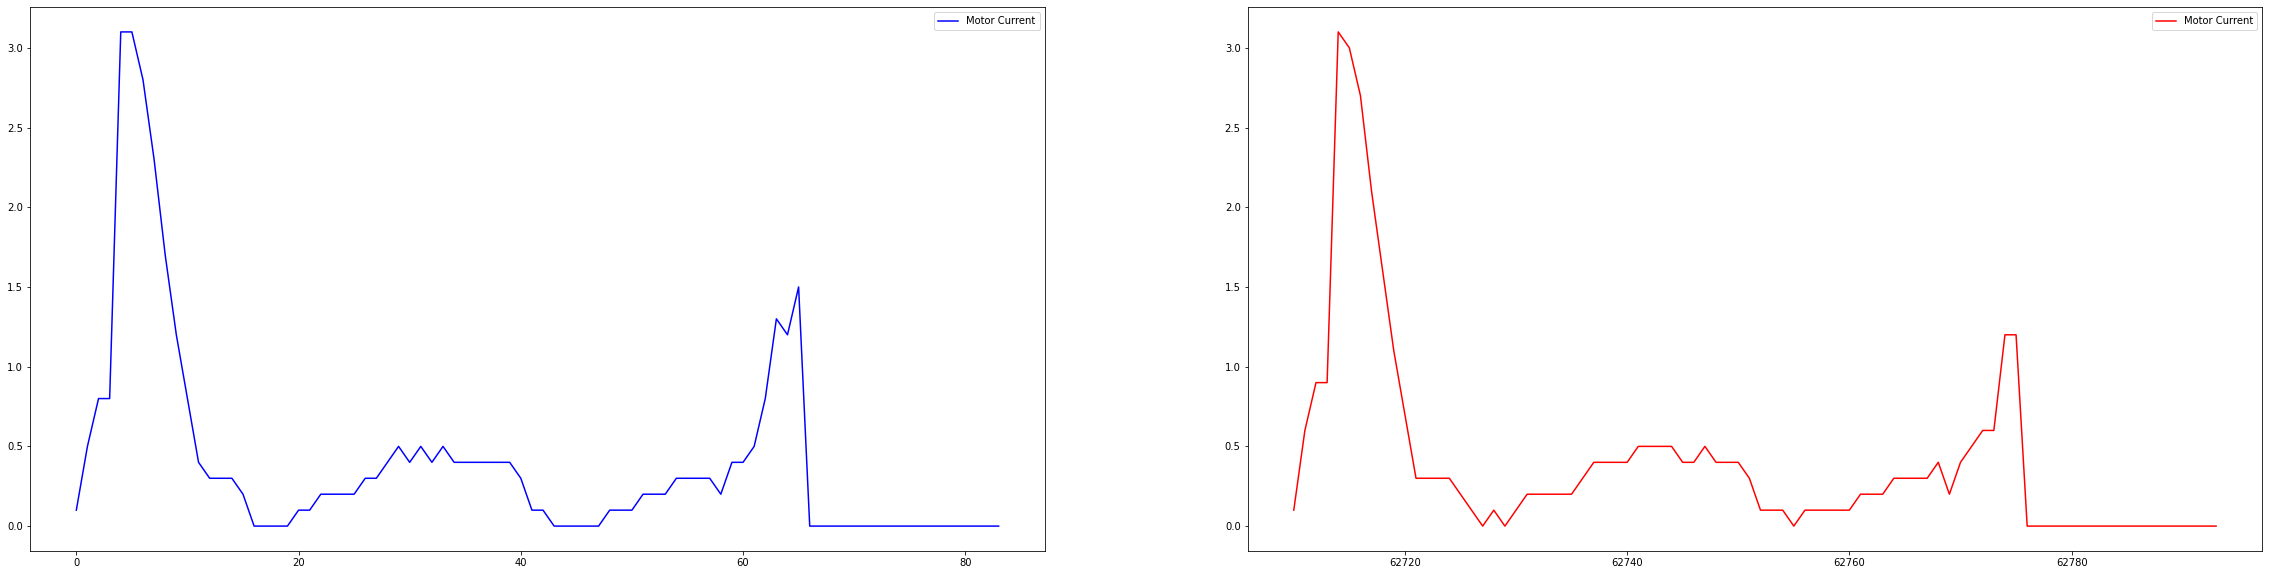

In [64]:
plt.figure(figsize=(40,10))
ax1 = plt.subplot(1,2,1)
plt.plot(df_class0['MA'], 'b')
plt.legend(['Motor Current', 'Class-0'])

ax2 = plt.subplot(1,2,2)
plt.plot(df_class2['MA'], 'r')
plt.legend(['Motor Current', 'ClaSS-2'])


#KNN Model

In [49]:
knn = KNeighborsClassifier(n_neighbors = 4, weights='distance')
knn.fit(x_train_scaled, y_train)
y_pred = knn.predict(x_test_scaled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [43]:
accuracy_score(y_test, y_pred)

0.9433333333333334

In [44]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5])
cm

array([[192,   2,   3,   0,   0,   0],
       [  1,  29,   0,   1,   1,   0],
       [  8,   0,   6,   0,   0,   0],
       [  0,   0,   0,  26,   0,   0],
       [  0,   0,   0,   0,  15,   0],
       [  0,   0,   0,   1,   0,  15]])


Confusion matrix, without normalization
[[192   2   3   0   0   0]
 [  1  29   0   1   1   0]
 [  8   0   6   0   0   0]
 [  0   0   0  26   0   0]
 [  0   0   0   0  15   0]
 [  0   0   0   1   0  15]]



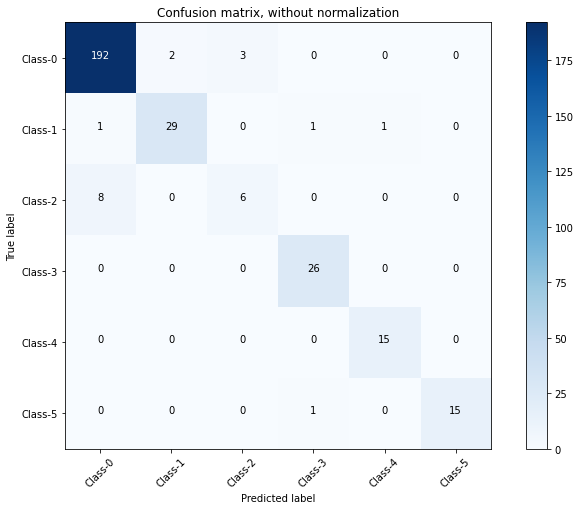


Normalized confusion matrix
[[ 97.46192893   1.01522843   1.52284264   0.           0.
    0.        ]
 [  3.125       90.625        0.           3.125        3.125
    0.        ]
 [ 57.14285714   0.          42.85714286   0.           0.
    0.        ]
 [  0.           0.           0.         100.           0.
    0.        ]
 [  0.           0.           0.           0.         100.
    0.        ]
 [  0.           0.           0.           6.25         0.
   93.75      ]]



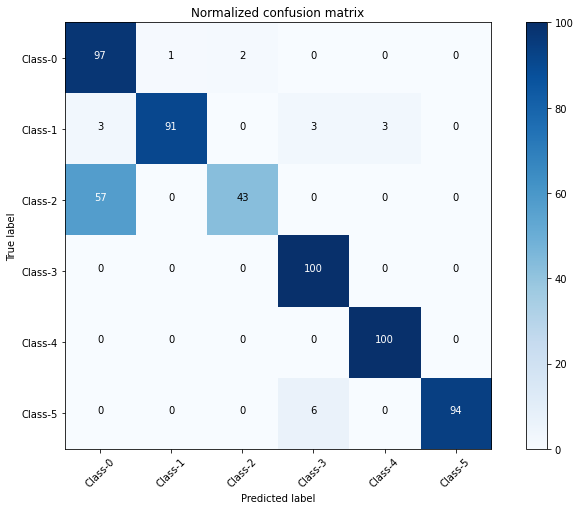

In [45]:
class_names = ['Class-0','Class-1','Class-2','Class-3','Class-4','Class-5']
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')

http://programstudio.co.kr/2019-08-10-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%ED%9A%8C%EA%B7%80%EC%9D%98-%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C-%EB%AA%A8%EB%8D%B8-%EC%84%A0%ED%83%9D%EC%97%90%EC%84%9C-%ED%8F%89%EA%B0%80/

In [46]:
targets = ['Class-0', 'Class-1', 'Class-2', 'Class-3', 'Class-4', 'Class-5']
print(classification_report(y_test, y_pred, target_names=targets))

              precision    recall  f1-score   support

     Class-0       0.96      0.97      0.96       197
     Class-1       0.94      0.91      0.92        32
     Class-2       0.67      0.43      0.52        14
     Class-3       0.93      1.00      0.96        26
     Class-4       0.94      1.00      0.97        15
     Class-5       1.00      0.94      0.97        16

    accuracy                           0.94       300
   macro avg       0.90      0.87      0.88       300
weighted avg       0.94      0.94      0.94       300



#Cross-validation with Random Forest

In [47]:
x_data = result.iloc[:,2:]
y_data = result.iloc[:,1:2]

scaler = StandardScaler()
scaler.fit(x_data)
x_data_scaled = scaler.transform(x_data)

In [48]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=20)
kf = KFold(n_splits=10, shuffle=True, random_state=0)
score = cross_val_score(rf, x_data, y_data, cv=kf)

print(score.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/s

0.9459494949494951


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



#Hyperparameter Simulation
  - Random Forest

In [49]:
rf_param_grid = {
    'n_estimators' : [10,20,40,50],
    'max_depth' : [5,10,12],
    'min_samples_leaf' : [2,3,5,7],
    'min_samples_split' : [3,5,7,9]
}

In [50]:
rf_grid = GridSearchCV(rf, param_grid=rf_param_grid, scoring='accuracy', n_jobs=-1, verbose=1)

In [51]:
rf_grid.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,


In [52]:
rf_grid.best_score_ #최고점수

0.9456423432682426

In [ ]:
rf_grid.best_params_ #최고 점수를 낸 파라미터

{'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 50}

In [ ]:
rf_grid.best_estimator_ #최고 점수를 낸 파라미터를 가진 모델 리턴

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 - KNN : Cross-validation을 이용해 k 찾기

In [ ]:
#전체 Feature
x_data = result.iloc[:,2:]
y_data = result.iloc[:,1:2]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


#특정 Feature 추출 
x_data2 = result[['MA_CLEARANCE', 'MA_CREST', 'MA_IMPULSE', 'MA_SKEW', 'MS_MEAN', 'MA_RSS', 'MS_STD']]
y_data2 = result.iloc[:,1:2]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2, test_size=0.3, random_state=1)

scaler = StandardScaler()
scaler.fit(x_train2)
x_train2_scaled = scaler.transform(x_train2)
x_test2_scaled = scaler.transform(x_test2)

전체 Feautre 사용하여 최적의 k값 찾기

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packag

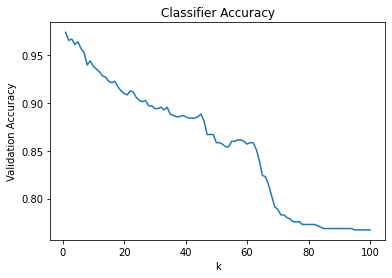

In [ ]:
k_range = range(1,101)
k_scores = []

for k in k_range:
  classifier = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(classifier, x_train_scaled, y_train, cv=10, scoring='accuracy')
  k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Classifier Accuracy")
plt.show()

In [ ]:
k_scores

[0.9742857142857144,
 0.9657142857142856,
 0.9671428571428571,
 0.9614285714285714,
 0.9642857142857144,
 0.9571428571428571,
 0.9528571428571428,
 0.9400000000000001,
 0.9442857142857143,
 0.9385714285714286,
 0.9357142857142857,
 0.9328571428571429,
 0.9285714285714286,
 0.9271428571428573,
 0.9228571428571429,
 0.9214285714285715,
 0.9228571428571429,
 0.9171428571428573,
 0.912857142857143,
 0.9099999999999999,
 0.9085714285714286,
 0.9128571428571428,
 0.9114285714285714,
 0.9057142857142857,
 0.9028571428571428,
 0.9014285714285715,
 0.9028571428571428,
 0.8971428571428571,
 0.8971428571428571,
 0.8942857142857144,
 0.8942857142857144,
 0.8957142857142857,
 0.8928571428571429,
 0.8957142857142857,
 0.8885714285714286,
 0.8871428571428572,
 0.8857142857142858,
 0.8857142857142858,
 0.8871428571428572,
 0.8857142857142858,
 0.8842857142857143,
 0.8842857142857143,
 0.8842857142857143,
 0.8857142857142858,
 0.8885714285714286,
 0.8814285714285715,
 0.8671428571428571,
 0.86714285714

중요 Feautre 선택해서 k값 찾기

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packag

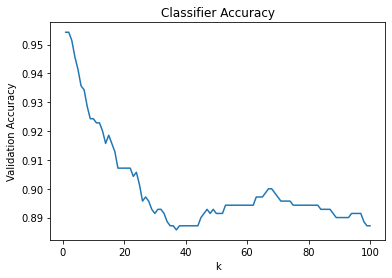

In [ ]:
k_range = range(1,101)
k_scores = []

for k in k_range:
  classifier = KNeighborsClassifier(n_neighbors = k, weights='distance') #weights=uniform/distance
  scores = cross_val_score(classifier, x_train2_scaled, y_train2, cv=10, scoring='accuracy')
  k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Classifier Accuracy")
plt.show()

In [ ]:
k_scores

[0.9542857142857143,
 0.9542857142857143,
 0.9514285714285714,
 0.9457142857142857,
 0.9414285714285715,
 0.9357142857142857,
 0.9342857142857144,
 0.9285714285714286,
 0.9242857142857144,
 0.9242857142857144,
 0.9228571428571429,
 0.9228571428571429,
 0.9200000000000002,
 0.9157142857142858,
 0.9185714285714287,
 0.9157142857142858,
 0.912857142857143,
 0.9071428571428571,
 0.9071428571428571,
 0.9071428571428571,
 0.9071428571428571,
 0.9071428571428571,
 0.9042857142857142,
 0.9057142857142857,
 0.9014285714285715,
 0.8957142857142857,
 0.8971428571428571,
 0.8957142857142857,
 0.8928571428571429,
 0.8914285714285715,
 0.8928571428571429,
 0.8928571428571429,
 0.8914285714285715,
 0.8885714285714286,
 0.8871428571428572,
 0.8871428571428572,
 0.8857142857142858,
 0.8871428571428572,
 0.8871428571428572,
 0.8871428571428572,
 0.8871428571428572,
 0.8871428571428572,
 0.8871428571428572,
 0.8871428571428572,
 0.89,
 0.8914285714285715,
 0.8928571428571429,
 0.8914285714285715,
 0.8928

#Ensemble

In [ ]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=20)
svm = SVC(gamma='auto', probability=True)
knn = KNeighborsClassifier(n_neighbors = 4, weights='distance')

voting_clf = VotingClassifier(
    estimators = [('rf', rf),('svm',svm), ('knn', knn)],
    voting = 'soft'
)
voting_clf.fit(x_train_scaled, y_train)
y_pred = voting_clf.predict(x_test_scaled)

accuracy_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.9433333333333334

모델별 vs Ensemble 분류 정확도

In [ ]:
for clf in (rf,svm,knn,voting_clf):
  clf.fit(x_train_scaled, y_train)
  y_pred = clf.predict(x_test_scaled)

  print("{}, {}".format(clf.__class__.__name__, accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWar

RandomForestClassifier, 0.95
SVC, 0.92
KNeighborsClassifier, 0.9433333333333334
VotingClassifier, 0.94
